# Applications of Eigenvalues and Eigenvectors: Point Cloud Registration

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Singular Value Decomposition

Recall:

**Theorem (Singular Value Decomposition)**

Any matrix $A \in \mathbb{R}^{m \times n}$ (with, say, $m \geq n$) can be decomposed as 
$$
A = U\Sigma V^T,
$$
where $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are *orthogonal matrices* (their columns for an orthonormal basis for their respective vector spaces) and $\Sigma$ has a block diagonal structure.

In particular, the columns of $V$ are eigenvectors of $A^T A$, one block of $\Sigma$ contains square roots of the (real, non-negative) eigenvalues of $A^T A$ and the columns of $U$ are eigenvectors of $AA^T$.

This is called the *Singular Value Decomposition (SVD)* of $A$.

We will now show how to use the SVD for matching point clouds in a geometric data analysis context.

### Loading and Processing Data

We'll use a dataset consisting of point clouds sampled from 3D models of horse figures. The models in the dataset come from an animation of a horse running.

In [2]:
path='./data/meshes.npy'
tab_obj=np.load(path)

Let's take a look at an example.

In [3]:
idx = 5
X=tab_obj[idx]

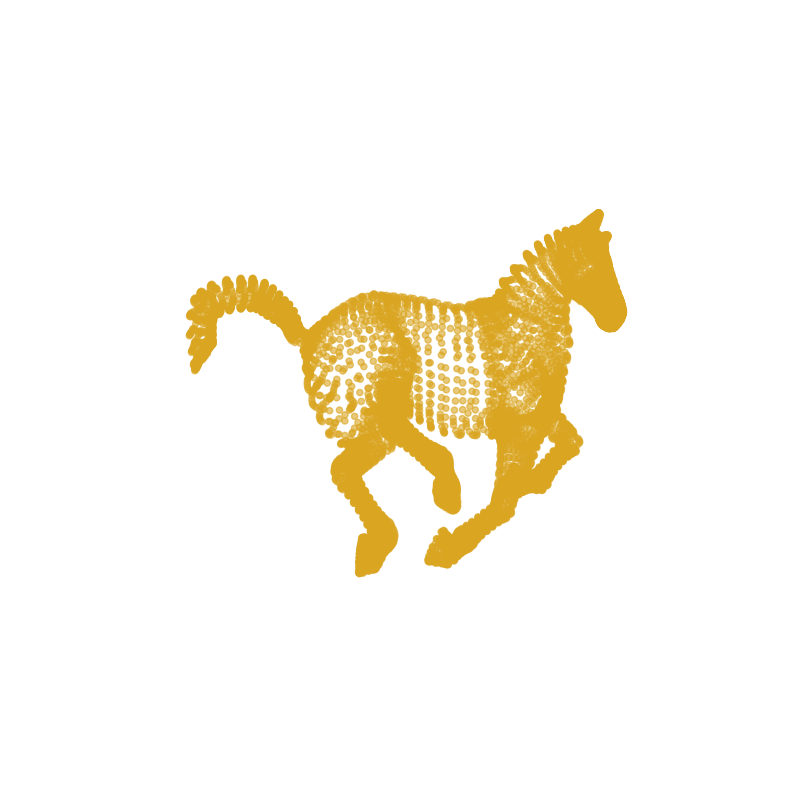

In [4]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,2],X[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

### Point Cloud Registration

In this section, we aim to address the the

**Point Cloud Registration Problem:** Given two 3D point cloud models, how do we optimally align the point clouds in space, as a processing step for downstream analysis?

The data that we're using is already aligned pretty well, so let's write a function to introduce adversarial rotations.

In [5]:
def randomlyRotatePointCloud(X, angle_bound = np.pi/3):
    
    theta1 = np.random.rand()*angle_bound
    A1 = np.array([[1,0,0],
                  [0, np.cos(theta1),-np.sin(theta1)],
                   [0, np.sin(theta1),np.cos(theta1)]])
    theta2 = np.random.rand()*angle_bound
    A2 = np.array([[np.cos(theta2),0,-np.sin(theta2)],
                  [0, 1, 0],
                   [np.sin(theta2), 0,np.cos(theta2)]])
    theta3 = np.random.rand()*angle_bound
    A3 = np.array([[np.cos(theta3),-np.sin(theta3),0],
                  [np.sin(theta3),np.cos(theta3) ,0],
                   [0,0 ,1]])
    
    X_rot = X@A3@A2@A1
    
    return X_rot

Testing our function:

In [6]:
Y = randomlyRotatePointCloud(X)

# The following centers the pointclouds to help with visualization
X -= np.mean(X,axis = 0)
Y -= np.mean(Y,axis = 0)

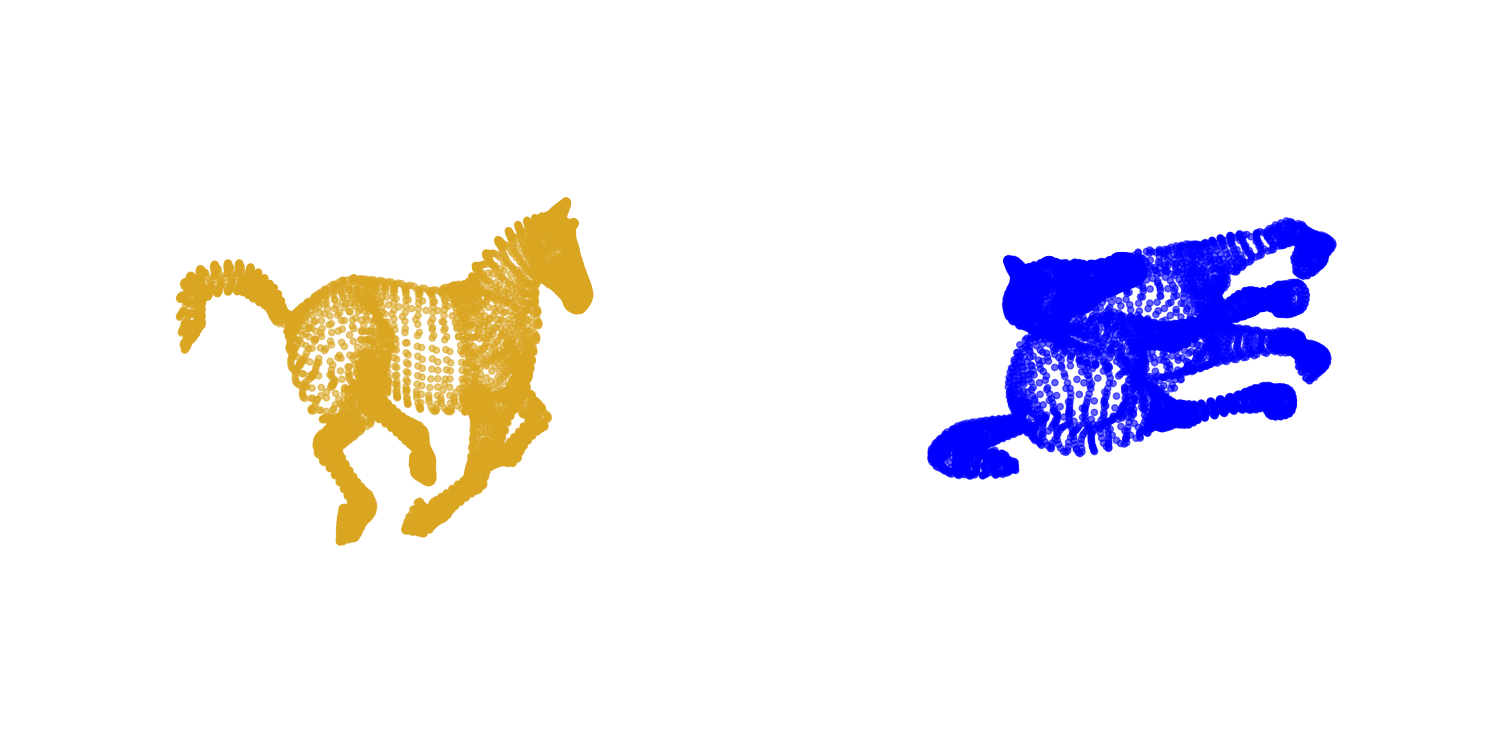

In [7]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0],X[:,2],X[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

ax = fig.add_subplot(122, projection='3d')
ax.scatter(Y[:,0],Y[:,2],Y[:,1], marker='o', s=20, c='blue', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

plt.tight_layout()

Plotting the point clouds on top of one another shows the misalignment.

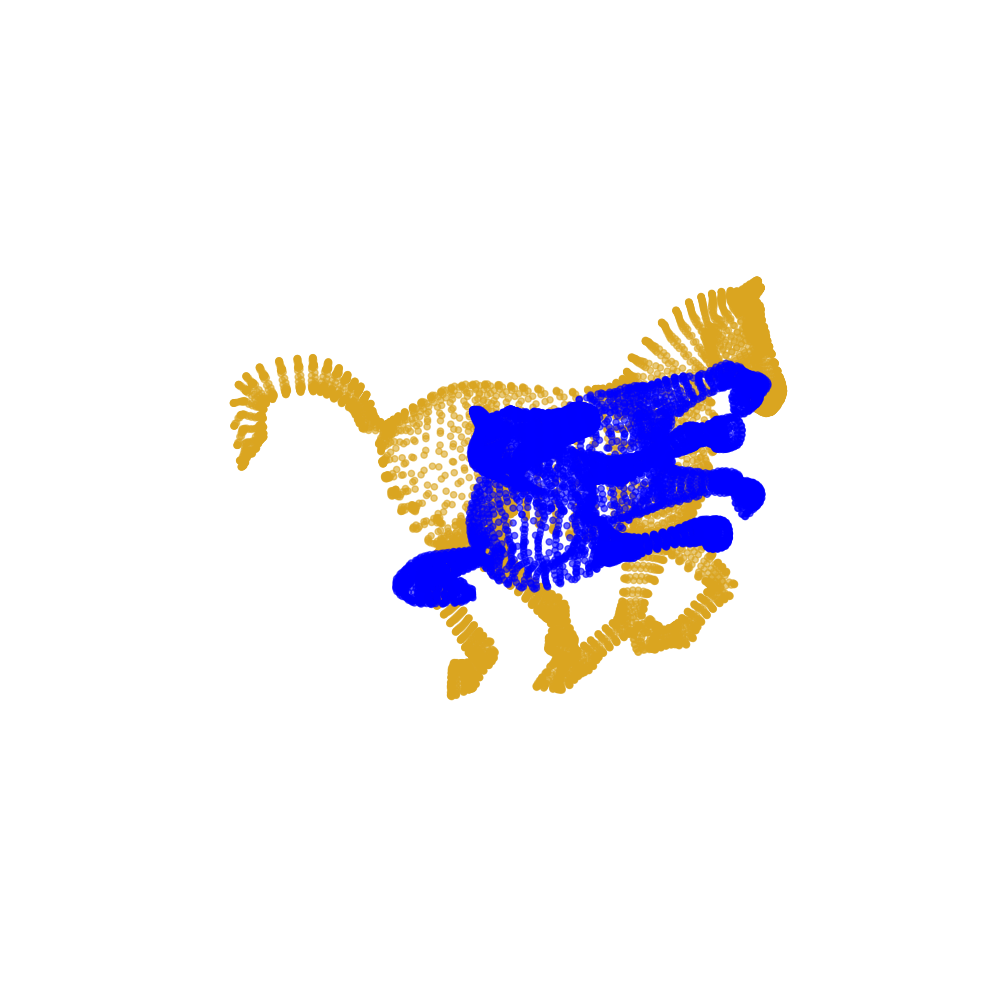

In [8]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,2],X[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
ax.scatter(Y[:,0],Y[:,2],Y[:,1], marker='o', s=20, c='blue', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

plt.tight_layout()

Given two arbitrary point clouds, we can first align them by *centering*---i.e., by ensuring that their means lie at the origin. This is what we did for PCA, and has already been applied in the figure above. 

However, we see that centering is not enough to align the point clouds: we also need to align them by rotating and/or reflecting.

## Problem Setup: 

Assume that the point clouds are already "in correspondence", i.e., we know that $\vec{x}_1$ should be matched up with $\vec{y}_1$, et cetera. 

**Note:** The correspondence assumption is restrictive. In practice, we may not know the correspondence between points which makes the problem *much* more difficult!

Recall that rotations and reflections correspond to multiplication by orthogonal matrices. Suppose that we have two point clouds $\{\vec{x}_1,\ldots,\vec{x}_m\}$ and $\{\vec{y}_1,\ldots,\vec{y}_m\}$ in $\mathbb{R}^n$. We then want to solve the optimization problem:

$$
\mbox{minimize} \quad \sum_{i=1}^m \|\vec{y}_i - W \vec{x}_i\|^2 \quad \mbox{subject to} \quad W \; \mbox{ is an orthogonal matrix}
$$

This problem has a **closed form solution**:

- Set $A = \sum_{i=1}^m \vec{x}_i \vec{y}_i^T \in \mathbb{R}^{n \times n}$.
- Denote the SVD of $A$ as $A = U \Sigma V^T$. 
- The optimal orthogonal matrix $W$ is given by $W = VU^T$.

Let's apply this to our example. 

Note that, if we express the point clouds as data matrices $X,Y \in \mathbb{R}^{m \times n}$, then the matrix $A$ defined above is given by $A = X^T Y$. 

To apply the orthogonal matrix $W$ to each vector in the dataset for $X$, and end up with a data matrix, the computation looks like
$$
(WX^T)^T = XW^T.
$$

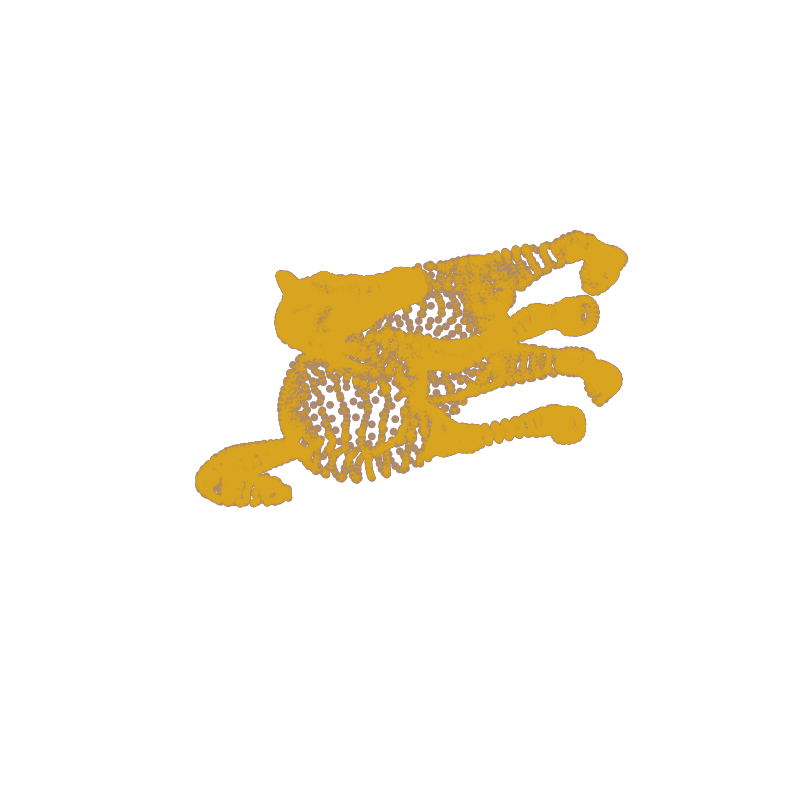

In [9]:
A = X.T@Y
U, Sigma, Vt = np.linalg.svd(A, full_matrices=True)

XRot = X@(Vt.T@U.T).T

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:,0],X[:,2],X[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
# ax.scatter(YRot[:,0],YRot[:,2],YRot[:,1], marker='o', s=20, c='blue', alpha=0.6)
ax.scatter(XRot[:,0],XRot[:,2],XRot[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
ax.scatter(Y[:,0],Y[:,2],Y[:,1], marker='o', s=20, c='blue', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

We see that our formula perfectly lined up the point clouds!

### Another Example

Let's try this when we don't have a copy of exactly the same horse.

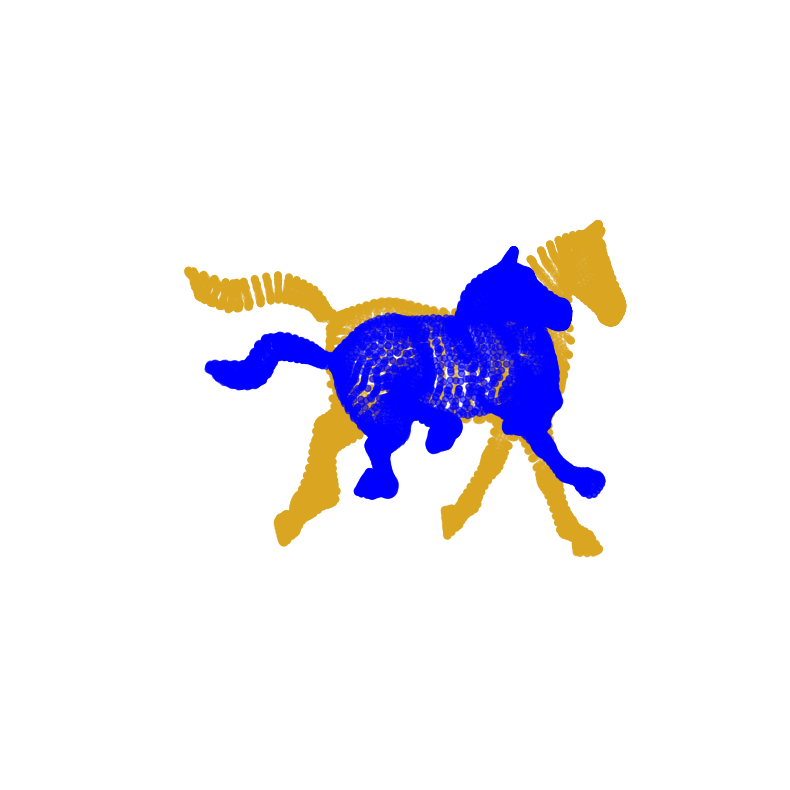

In [10]:
idx = 1
idy = 2

X=tab_obj[idx]
Y=tab_obj[idy]

Y = randomlyRotatePointCloud(Y)

# The following centers the pointclouds to help with visualization
X -= np.mean(X,axis = 0)
Y -= np.mean(Y,axis = 0)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,2],X[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
ax.scatter(Y[:,0],Y[:,2],Y[:,1], marker='o', s=20, c='blue', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

Running the alignment algorithm again:

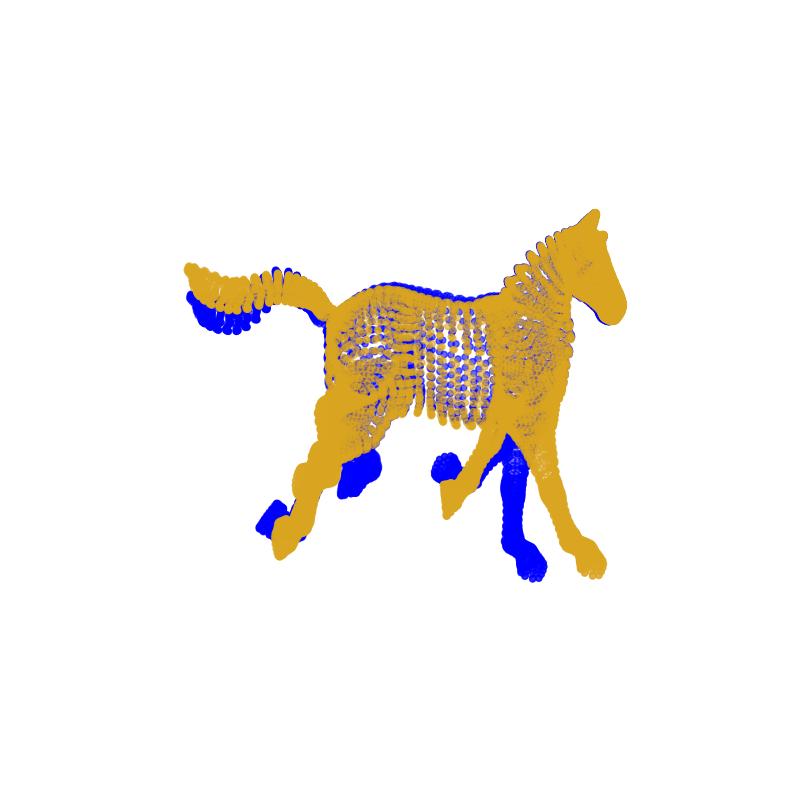

In [11]:
A = X.T@Y
U, Sigma, Vt = np.linalg.svd(A, full_matrices=True)

YRot = Y@Vt.T@U.T

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,2],X[:,1], marker='o', s=20, c='goldenrod', alpha=0.6)
ax.scatter(YRot[:,0],YRot[:,2],YRot[:,1], marker='o', s=20, c='blue', alpha=0.6)
ax.view_init(elev=10., azim=360)
ax.set_axis_off()

This is the best possible alignment of the horses, which are in different poses.